## Singapore Private Property 
This set of python codes serve to download past 5 years' of URA private property transactions from URA API for purpose of providing a basis for further data analysis.

The raw data will undergo basic cleaning and then saved into csv file for archival (because URA will continuously remove data older than 5 years old).

In [1]:
import pandas as pd
import requests
from collections import Counter
import datetime as dt
import re
import matplotlib.pyplot as plt

In [2]:
#token given by URA
ura_access_key = 'd8722f05-25ff-44f6-bb6f-5d728aa4c9b1'

#getting the token for the day
r = requests.get("https://www.ura.gov.sg/uraDataService/insertNewToken.action", headers={"AccessKey":ura_access_key})
token = r.json()['Result']

In [3]:
#accessing the data in 4 batches as required by URA API
for i in range(1,5):
    #requesting data by passing in access key and token, in 4 batches as stated in URA API website
    req = requests.get('https://www.ura.gov.sg/uraDataService/invokeUraDS?service=PMI_Resi_Transaction&batch=' + str(i),
                      headers={"AccessKey":ura_access_key, "Token":token})
    
    df_temp = pd.json_normalize(req.json()['Result'], 'transaction', ['street','x','y','project'],errors='ignore')

    #adding each batch to DataFrame
    if i==1:
        df = df_temp
    else:
        df = df.append(df_temp, ignore_index=True) #ignore index so that append can be done
    
    #printing the progress for monitoring
    print('Batch ' + str(i) + ' completed')

Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113036 entries, 0 to 113035
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   area          113036 non-null  object
 1   floorRange    113036 non-null  object
 2   noOfUnits     113036 non-null  object
 3   contractDate  113036 non-null  object
 4   typeOfSale    113036 non-null  object
 5   price         113036 non-null  object
 6   propertyType  113036 non-null  object
 7   district      113036 non-null  object
 8   typeOfArea    113036 non-null  object
 9   tenure        113036 non-null  object
 10  nettPrice     1137 non-null    object
 11  street        113036 non-null  object
 12  x             88181 non-null   object
 13  y             88181 non-null   object
 14  project       113036 non-null  object
dtypes: object(15)
memory usage: 12.9+ MB


In [5]:
#saving raw data to local drive
this_year = dt.date.today().year
this_month = dt.date.today().month

df.to_csv("ura_caveats downloaded year " + str(this_year) + ' month ' + str(this_month) + " raw data.csv")

In [6]:
#making copy of df
df1 = df.copy()

#performing basic tidying up

#nett price is final selling price, hence will replace price if nettprice is not null
df1.loc[df1['nettPrice'].notnull(),'price'] = df1.loc[df1['nettPrice'].notnull(),'nettPrice']

#remove nettprice and geo-coordinates
df1 = df1.drop(['nettPrice','x','y'],axis=1)

#convert area to sq feet, and type float
df1.area = df1.area.astype('float') * 10.76

#forcing to numeric before changing to int type
df1.price = pd.to_numeric(df1.price, errors='coerce').astype('int')

#create new column to hold calculated psf price
df1['Unit Price psf'] = (df1['price']/df1['area']).astype('int')

#parsing the contract date to proper pandas datetime format
df1.contractDate = pd.to_datetime(df1.contractDate, format='%m%y').dt.to_period('M')

In [7]:
#checking out the tenure column and find a way standardize data
print(Counter(df1.tenure))

Counter({'Freehold': 32022, '99 yrs lease commencing from 2018': 12180, '99 yrs lease commencing from 2014': 8849, '99 yrs lease commencing from 2015': 7420, '99 yrs lease commencing from 2016': 5990, '99 yrs lease commencing from 2013': 5330, '99 yrs lease commencing from 2017': 4789, '99 yrs lease commencing from 2011': 4010, '99 yrs lease commencing from 2012': 3700, '99 yrs lease commencing from 2010': 3217, '99 yrs lease commencing from 2019': 2432, '99 yrs lease commencing from 1997': 2312, '99 yrs lease commencing from 2008': 1746, '99 yrs lease commencing from 1996': 1498, '99 yrs lease commencing from 1995': 1264, '99 yrs lease commencing from 2000': 1158, '99 yrs lease commencing from 2007': 1121, '99 yrs lease commencing from 2006': 959, '99 yrs lease commencing from 1994': 924, '99 yrs lease commencing from 2002': 810, '99 yrs lease commencing from 2001': 789, '99 yrs lease commencing from 1993': 742, '99 yrs lease commencing from 2009': 721, '99 yrs lease commencing from 2

In [8]:
for i in range(df1.shape[0]):
    if (df1.loc[i,'tenure'] == 'NA'):
        #set data where tenure is NA to 999 years
        df1.loc[i,'lease left'] = 999
    elif (df1.loc[i,'tenure'][2] == ' ') & (df1.loc[i,'tenure'][-4:]=='hold'):
        #set data where tenure is 99 years but without start year to 99
        df1.loc[i,'lease left'] = 99
    elif (df1.loc[i,'tenure'][0] == '1'):
        df1.loc[i,'lease left'] = int(df1.loc[i,'tenure'][0:3]) - this_year + int(df1.loc[i,'tenure'][-4:])
    elif df1.loc[i,'tenure'][2] == ' ':
        df1.loc[i,'lease left'] = int(df1.loc[i,'tenure'][0:2]) - this_year + int(df1.loc[i,'tenure'][-4:])
    else:
        df1.loc[i,'lease left'] = 999

In [9]:
#checking the rest of the columns to make sure there is no unusual entries
print(Counter(df1.typeOfSale))
print(Counter(df1.propertyType))
print(Counter(df1.district))
print(Counter(df1.typeOfArea))

Counter({'3': 57241, '1': 54137, '2': 1658})
Counter({'Condominium': 51069, 'Apartment': 37418, 'Executive Condominium': 13093, 'Terrace': 5424, 'Semi-detached': 3094, 'Detached': 1410, 'Strata Terrace': 1193, 'Strata Semi-detached': 257, 'Strata Detached': 78})
Counter({'19': 17400, '15': 8021, '18': 6938, '23': 6885, '05': 6843, '03': 6578, '14': 6480, '10': 6109, '27': 5797, '09': 5159, '16': 4329, '13': 4074, '20': 3909, '21': 3647, '11': 2964, '28': 2957, '12': 2726, '22': 2549, '17': 1677, '25': 1606, '04': 1339, '08': 1245, '01': 1041, '02': 987, '07': 897, '26': 874, '06': 5})
Counter({'Strata': 103089, 'Land': 9947})


In [10]:
#Splitting into 2 dataframes: landed transactions and non-landed property transactions

df_non_landed = df1[df1.propertyType.isin(['Condominium','Apartment','Executive Condominium'])]
df_landed = df1[df1.propertyType.isin(['Terrace','Semi-detached','Detached','Strata Terrace',
                                       'Strata Semi-detached','Strata Detached'])]

In [11]:
#remove floorRange column of landed because it is not relevant
df_landed = df_landed.drop(['floorRange'],axis=1)

In [22]:
#checking for errors in floorRange column
print(df_non_landed.floorRange.value_counts())

#amend the floorRange error in original URA data 
df_non_landed.loc[df_non_landed['floorRange']=='B1-B5','floorRange'] = '01-05'
df_non_landed.loc[df_non_landed['floorRange']=='-','floorRange'] = '01-05'

01-05    36323
06-10    26861
11-15    19264
16-20     8993
21-25     4157
26-30     2610
31-35     1824
36-40      875
41-45      306
46-50      116
51-55       62
56-60       36
61-65       25
66-70       21
71-75        4
Name: floorRange, dtype: int64


In [13]:
#convert data types of various columns
df_non_landed = df_non_landed.astype({'area':'int32','noOfUnits':'int32','floorRange':'category',
                                      'typeOfSale':'category','propertyType':'category',
                                      'district':'category','typeOfArea':'category','tenure':'str'})

df_landed = df_landed.astype({'area':'int32','noOfUnits':'int32','typeOfSale':'category','propertyType':'category',
                              'district':'category','typeOfArea':'category','tenure':'str'})

In [14]:
#finding out the en-bloc sales data
display(df_non_landed[df_non_landed.noOfUnits>1].sort_values('noOfUnits'))

#further splitting the en-bloc non-landed transactions from the non-landed dataframe
#enbloc deals are picked up by dual conditions of large deal value of more than $20mil and >1 unit per transaction.
#this is not a perfect method but is able to pick up all enbloc deals while minimizing non-enbloc transactions

df_enbloc = df_non_landed[(df_non_landed.noOfUnits>1) & (df_non_landed.price>20000000)]
df_non_landed = df_non_landed[(df_non_landed.noOfUnits<=10) & (df_non_landed.price<=20000000)]

#convert data types of various columns
df_enbloc = df_enbloc.astype({'area':'int32','noOfUnits':'int32','floorRange':'category',
                              'typeOfSale':'category','propertyType':'category','district':'category',
                              'typeOfArea':'category','tenure':'str'})

,area,floorRange,noOfUnits,contractDate,typeOfSale,price,propertyType,district,typeOfArea,tenure,street,project,Unit Price psf,lease left
33746,2255,01-05,2,2016-12,3,3400000,Apartment,14,Land,9999 yrs lease commencing from 1965,LORONG 24 GEYLANG,PERPETUAL APARTMENTS,1507,999.0
45361,3346,21-25,2,2017-11,3,6000000,Apartment,09,Strata,Freehold,ST. THOMAS WALK,SKYPARK,1792,999.0
44563,5659,11-15,2,2019-10,3,20000000,Apartment,09,Strata,Freehold,CAIRNHILL ROAD,THE RITZ-CARLTON RESIDENCES SINGAPORE CAIRNHILL,3533,999.0
30097,2797,01-05,2,2020-07,3,1950000,Apartment,12,Strata,Freehold,BALESTIER ROAD,EASTPAC BUILDING,697,999.0
18718,8629,01-05,2,2017-11,3,16485142,Apartment,09,Strata,Freehold,KILLINEY ROAD,TAI WAH BUILDING,1910,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36865,558357,01-05,330,2017-05,3,765781819,Apartment,14,Strata,102 yrs lease commencing from 1986,SIMS AVENUE,EUNOSVILLE,1371,68.0
89747,563619,06-10,336,2017-10,3,629000000,Apartment,19,Strata,103 yrs lease commencing from 1985,HOUGANG AVENUE 2,FLORENCE REGENCY,1116,68.0
88517,600816,01-05,358,2016-05,3,638000000,Apartment,20,Strata,99 yrs lease commencing from 1986,SHUNFU ROAD,SHUNFU VILLE,1061,65.0
7932,629029,01-05,436,2018-01,3,840888888,Condominium,05,Strata,99 yrs lease commencing from 1982,JALAN LEMPENG,PARK WEST,1336,61.0


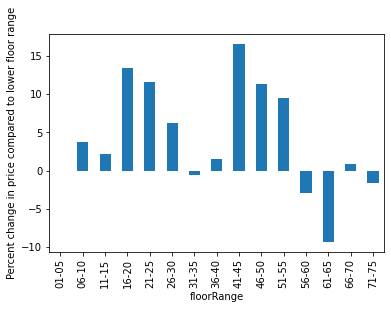

In [15]:
Price_change_floor = df_non_landed.groupby('floorRange')['Unit Price psf'].mean().pct_change()*100
Price_change_floor.plot(kind='bar')
_ = plt.ylabel("Percent change in price compared to lower floor range")

In [16]:
diff = df_non_landed.loc[df_non_landed.propertyType=='Apartment','Unit Price psf'].mean() - df_non_landed.loc[df_non_landed.propertyType=='Condominium','Unit Price psf'].mean()
print(diff)

223.58076437338173


In [17]:
df_non_landed.groupby('district')['Unit Price psf'].mean().sort_values()

district
25     785.941982
27     912.089618
17     974.145530
23     978.526545
26    1035.840741
22    1075.041806
18    1097.670835
28    1133.485759
19    1157.214207
16    1172.698527
05    1383.794623
12    1396.160808
21    1399.798804
20    1421.305864
14    1442.296862
08    1445.895425
15    1476.054799
04    1509.728132
13    1569.991168
11    1718.546271
03    1790.764079
10    2044.090839
01    2168.831892
02    2184.799796
09    2221.391415
07    2252.053631
06    2297.500000
Name: Unit Price psf, dtype: float64

In [18]:
df_landed.groupby('district')['Unit Price psf'].mean().sort_values()

district
25     747.930556
27     778.513369
22     781.929936
17     877.085837
18     898.542373
16    1003.415704
12    1050.469388
23    1071.863946
19    1106.371216
05    1148.817829
14    1150.088803
28    1174.282651
26    1200.856287
20    1221.603293
13    1226.071048
21    1329.010730
03    1338.000000
15    1410.411072
08    1435.619048
11    1563.277322
10    1569.542484
04    1689.728571
02    2833.400000
09    3034.179487
Name: Unit Price psf, dtype: float64

In [19]:
#saving the cleaned data into csv
df_non_landed.to_csv("Non-landed transactions downloaded and cleaned on year " + str(this_year) + " month " + str(this_month) + ".csv")
df_landed.to_csv("landed transactions downloaded and cleaned on year " + str(this_year) + " month " + str(this_month) + ".csv")
df_enbloc.to_csv("enbloc transactions downloaded and cleaned on year " + str(this_year) + " month " + str(this_month) + ".csv")

In [20]:
#Analysis of single condo project
condo = 'CARIBBEAN'
df_condo = df_non_landed[df_non_landed['project'].str.contains(condo)]
df_condo.groupby('floorRange')['Unit Price psf'].mean()

floorRange
01-05    1502.718750
06-10    1503.074074
11-15            NaN
16-20            NaN
21-25            NaN
26-30            NaN
31-35            NaN
36-40            NaN
41-45            NaN
46-50            NaN
51-55            NaN
56-60            NaN
61-65            NaN
66-70            NaN
71-75            NaN
Name: Unit Price psf, dtype: float64